Работа с датасетом MovieLens

https://grouplens.org/datasets/movielens/

См книгу 
Python for Data Analysis, Wes McKinney
2. Introductory Examples, MovieLens 1M Data Set (стр. 26)

1. Оценить количество фильмов, пользователей и оценок
2. Оценить распределения (предлагается построить распределения количества оценок по фильмам и пользователям и увидеть т.н. "длинные хвосты" в распределениях)
3. Оценить средние оценки по фильмам и по пользователям
4. Выбрать критерий, показывающий, что фильм нравится всем, или не нравится никому, и вывести топ фильмов из этих списков. Знаете ли вы эти фильмы, согласны ли с оценками?
5. Выбрать лучшие фильмы
6. Посмотреть на смещение оценок, увидеть сколько пользователей занижают оценки и завышают оценки.
7. Построить рекомендательную систему с помощью библиотеки surprise (или другой, по желанию). Применить подбор параметров модели на сетке, оценить качество полученной модели по выбранной вами метрике. 
8. Получить рекомендации для нового пользователя, совпадают ли они с лучшими фильмами?
9. Поставьте оценку какому-нибудь фильму (который вы знаете и можете поставить оценку) и получите рекомендации, насколько они качественные по вашим ощущениям? Сделайте это для фильма с негативной оценкой и для фильма с позитивной оценкой.
10. Добавляйте оценки и посмотрите, как изменяются рекомендации фильмов. Соответствуют ли они вашим предпочтениям? Есть ли недостатки у системы? Сколько нужно оценок для того, чтобы рекомендации стали релевантными? (в этом пункте добавляйте оценки в том числе из интересного вам жанра для пункта 11)
11. Построить рекомендательную систему по подвыборке - выбрать интересный вам жанр. Изменились ли рекомендации? Стали лучше\хуже?
12(*). сделать самостоятельное исследование и выяснить, как добавить нового пользователя\фильм в систему без переобучения всей модели, описать архитектуру такого решения


In [218]:
import pandas as pd
# import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/mary/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['svd', 'test', 'split', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [219]:
rating = pd.read_csv('ml-latest-small/ratings.csv')

In [220]:
rating.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [221]:
movie = pd.read_csv('ml-latest-small/movies.csv')

In [222]:
movie.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [223]:
rating.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


1. Оценить количество фильмов, пользователей и оценок

In [224]:
rating.shape

(100836, 4)

В анализе принято оценок - 100836

Количество пользователей

In [225]:
len(rating.userId.unique())

610

Количество фильмов


In [226]:
len(movie.movieId.unique())

9742

2. Оценить распределения (предлагается построить распределения количества оценок по фильмам и пользователям и увидеть т.н. "длинные хвосты" в распределениях)


In [227]:
userId = rating['userId']

In [228]:
count_user = userId.value_counts()

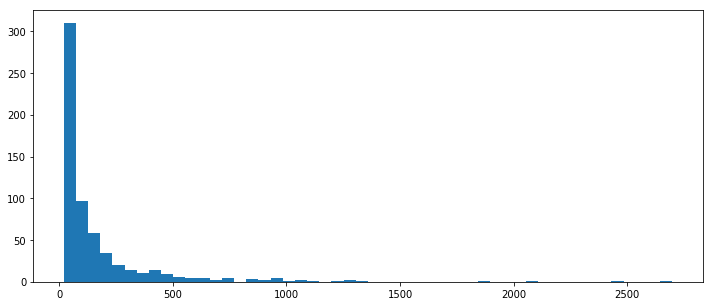

In [229]:
plt.figure(figsize=(12,5))
plt.hist(count_user,50);

основная часть ставит немного оценок

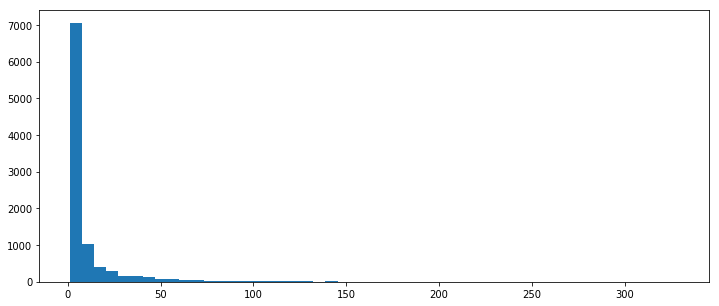

In [230]:
count_movie = rating.movieId.value_counts()
plt.figure(figsize=(12,5))
plt.hist(count_movie,50);

Аналогично с фильмами

3. Оценить средние оценки по фильмам и по пользователям

In [231]:
print('\nСредние оценки по фильмам:')
movie_rating = rating.groupby('movieId').agg({'rating':'mean'})
movie_rating.head(3)


Средние оценки по фильмам:


,rating
movieId,
1,3.920930
2,3.431818
3,3.259615


In [232]:
print('\nСредние оценки пользователей:')
rating.groupby('userId').agg({'rating':'mean'}).head(3)


Средние оценки пользователей:


,rating
userId,
1,4.366379
2,3.948276
3,2.435897


4. Выбрать критерий, показывающий, что фильм нравится всем, или не нравится никому, и вывести топ фильмов из этих списков. Знаете ли вы эти фильмы, согласны ли с оценками?


In [233]:
# Посмотрим на медиану и среднее количества оценок у фильма
np.mean(count_movie), np.median(count_movie)

(10.369806663924312, 3.0)

In [234]:
# Найдем средний рейтинг каждого фильма
movie_rating = rating.groupby('movieId').agg({'rating':'median'})

In [235]:
# Возьмем те фильмы, к которым отзывов больше среднего, добавим колонку с количеством отзывав и средним рейтингом фильма
most_reviewed = rating[rating.movieId.isin(count_movie[count_movie > 10].index)].copy()
most_reviewed = pd.merge(most_reviewed, count_movie.reset_index().rename(
    columns={'movieId':'review_counts', 'index':'movieId'}), on = ['movieId'], how='left')
most_reviewed = pd.merge(most_reviewed, movie_rating.reset_index().rename(
    columns={'rating':'median_rating'}), on='movieId', how='left')
most_reviewed = pd.merge(most_reviewed, movie[['movieId', 'title']], on='movieId', how='left')
most_reviewed=most_reviewed.drop(columns=['userId', 'rating', 'timestamp']).drop_duplicates()
most_reviewed.head()

,movieId,review_counts,median_rating,title
0,1,215,4.0,Toy Story (1995)
1,3,52,3.0,Grumpier Old Men (1995)
2,6,102,4.0,Heat (1995)
3,47,203,4.0,Seven (a.k.a. Se7en) (1995)
4,50,204,4.5,"Usual Suspects, The (1995)"


In [278]:
worst=most_reviewed.sort_values(by = ['review_counts', 'median_rating'],ascending=True)
best=most_reviewed.sort_values(by = ['review_counts', 'median_rating'],ascending=False)
# Худшие фильмы
worst.head()

,movieId,review_counts,median_rating,title
5669,3268,11,1.5,Stop! Or My Mom Will Shoot (1992)
6375,6793,11,1.5,Beethoven (1992)
2151,1474,11,2.0,Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)
2254,2153,11,2.0,"Avengers, The (1998)"
5167,2827,11,2.0,"Astronaut's Wife, The (1999)"
5228,3824,11,2.0,Autumn in New York (2000)
6316,3388,11,2.0,Harry and the Hendersons (1987)
6350,4340,11,2.0,"Animal, The (2001)"
14360,6482,11,2.0,Dumb and Dumberer: When Harry Met Lloyd (2003)
26438,46335,11,2.0,"Fast and the Furious: Tokyo Drift, The (Fast a..."


In [237]:
# Лучшие фильмы
best.head()

,movieId,review_counts,median_rating,title
20,356,329,4.0,Forrest Gump (1994)
209,318,317,4.5,"Shawshank Redemption, The (1994)"
16,296,307,4.5,Pulp Fiction (1994)
33,593,279,4.0,"Silence of the Lambs, The (1991)"
148,2571,278,4.5,"Matrix, The (1999)"


Среди фильмов, которые нравятся всем смотрела все, и они действительно очень хороши. Среди худших слышала лишь о двух, однако рейтинг IMDb подтверждает результат.

Критерий: фильмы, которые нравятся всем, как правило, имеют больше отзывов (помимо высокого рейтинга); а те, что не нравятся никому, имеют меньше всего оценок (и ниже рейтинг)

5. Выбрать лучшие фильмы

In [238]:
movie_rating = movie_rating.sort_values(by='rating', ascending = False).reset_index()
movies = pd.merge(movie_rating, movie[['movieId', 'title']], on='movieId', how='left')
movies

,movieId,rating,title
0,3942,5.0,Sorority House Massacre II (1990)
1,147250,5.0,The Adventures of Sherlock Holmes and Doctor W...
2,115122,5.0,What We Do in the Shadows (2014)
3,86237,5.0,Connections (1978)
4,1151,5.0,Lesson Faust (1994)
5,146662,5.0,Dragons: Gift of the Night Fury (2011)
6,114265,5.0,Laggies (2014)
7,146684,5.0,Cosmic Scrat-tastrophe (2015)
8,3851,5.0,I'm the One That I Want (2000)
9,5416,5.0,Cherish (2002)


Если оценивать лучшие фильмы только по рейтингу, то в топе оказываются незнакомые названия. Посмотрим, какое количество отзывов у этих фильмов.

In [239]:
pd.merge(movies, count_movie.reset_index().rename(
    columns={'movieId':'review_counts', 'index':'movieId'}), on = ['movieId'], how='left')

,movieId,rating,title,review_counts
0,3942,5.0,Sorority House Massacre II (1990),1
1,147250,5.0,The Adventures of Sherlock Holmes and Doctor W...,1
2,115122,5.0,What We Do in the Shadows (2014),3
3,86237,5.0,Connections (1978),1
4,1151,5.0,Lesson Faust (1994),2
5,146662,5.0,Dragons: Gift of the Night Fury (2011),1
6,114265,5.0,Laggies (2014),1
7,146684,5.0,Cosmic Scrat-tastrophe (2015),1
8,3851,5.0,I'm the One That I Want (2000),1
9,5416,5.0,Cherish (2002),1


И количество отзывов слишком мало, чтобы сказать, действительно ли фильмы хороши.

6. Посмотреть на смещение оценок, увидеть сколько пользователей занижают оценки и завышают оценки.


In [240]:
user_mean_rating = rating.groupby('userId').agg({'rating':'mean'})
mean_rating = np.mean(user_mean_rating)
lowering = user_mean_rating[user_mean_rating.rating < float(mean_rating)].shape[0]
uppering = user_mean_rating[user_mean_rating.rating > float(mean_rating)].shape[0]
print('Занижают рейтинг ' + str(lowering) + ' пользователя(ей)')
print('Завышают: ' + str(uppering) + ' пользователя(ей)')
print('Средний рейтинг по всем пользователям равен ' + str(float(mean_rating)))


Занижают рейтинг 287 пользователя(ей)
Завышают: 323 пользователя(ей)
Средний рейтинг по всем пользователям равен 3.657222337747402


7. Построить рекомендательную систему с помощью библиотеки surprise (или другой, по желанию). Применить подбор параметров модели на сетке, оценить качество полученной модели по выбранной вами метрике. 


In [153]:
# Чтение данных

In [148]:
# import sys
# !{sys.executable} -m pip install surprise

    100% |████████████████████████████████| 3.3MB 4.0MB/s eta 0:00:01
  Running setup.py bdist_wheel for scikit-surprise ... done
  Stored in directory: /Users/mary/Library/Caches/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [241]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate, GridSearchCV, split
from surprise import Reader, Dataset, SVD, evaluate
from surprise.accuracy import mae, rmse

In [265]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
train_set, test_set = split.train_test_split(data, 0.2, random_state=20)

In [243]:
svd_bias = SVD(random_state=20)
svd_no_bias = SVD(biased=False, random_state=20)

In [244]:
cross_validate(svd_bias, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8784  0.8689  0.8711  0.8701  0.8800  0.8737  0.0046  
MAE (testset)     0.6718  0.6692  0.6687  0.6684  0.6779  0.6712  0.0036  
Fit time          7.00    8.29    7.05    7.65    8.04    7.60    0.52    
Test time         0.23    0.25    0.23    2.92    0.26    0.78    1.07    


{'test_rmse': array([0.87843894, 0.86890059, 0.87108117, 0.87008273, 0.8800044 ]),
 'test_mae': array([0.67184341, 0.66921061, 0.66868593, 0.66835471, 0.67787028]),
 'fit_time': (6.997634172439575,
  8.288721084594727,
  7.0505640506744385,
  7.649715900421143,
  8.037846565246582),
 'test_time': (0.22825193405151367,
  0.24875283241271973,
  0.23066020011901855,
  2.91929292678833,
  0.25976133346557617)}

In [245]:
cross_validate(svd_no_bias, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9954  1.0003  0.9985  1.0026  0.9998  0.9993  0.0024  
MAE (testset)     0.7627  0.7655  0.7651  0.7667  0.7645  0.7649  0.0013  
Fit time          7.38    7.04    9.17    7.14    7.12    7.57    0.81    
Test time         0.17    0.17    0.18    0.18    0.18    0.17    0.01    


{'test_rmse': array([0.99539891, 1.00030559, 0.99849496, 1.00259401, 0.99983234]),
 'test_mae': array([0.76267744, 0.76552317, 0.76510821, 0.76666453, 0.7644793 ]),
 'fit_time': (7.37916374206543,
  7.042771100997925,
  9.169454097747803,
  7.143927097320557,
  7.124254941940308),
 'test_time': (0.16950702667236328,
  0.1680009365081787,
  0.17771482467651367,
  0.1795210838317871,
  0.18024706840515137)}

In [246]:
from time import time

In [254]:
t=time()
param_grid = {
    'lr_all': [0.005, 0.05],
    'reg_all': [0.02, 0.002],
    'n_factors': [5, 10, 100, 500],
    'n_epochs': [10, 100]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

print('Time spend: {} mins'.format(round((time() - t) / 60, 2)))
# best RMSE score
print(gs.best_score['rmse'])

Time spend: 55.01 mins
0.8696649155867973


In [255]:
gs.best_params

{'rmse': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100},
 'mae': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100}}

In [257]:
# Without GridSearch
svd_1 = SVD(biased=True, random_state=20)
svd_1.train(train_set)

In [273]:
pred = svd_1.test(test_set)
mae(pred); rmse(pred);

MAE:  0.6707
RMSE: 0.8758


Для работы взяли SVD с bias. По результатам подбора параметров через GridSearchCV получили RMSE = 0.8697

In [344]:
svd = SVD(**gs.best_params['rmse'], random_state=20)
svd_fited = svd.fit(train_set)
predictions = svd_fited.test(test_set)

In [345]:
rmse(predictions);

RMSE: 0.8675


8. Получить рекомендации для нового пользователя, совпадают ли они с лучшими фильмами?


In [346]:
movieIds_unique = df.movieId.unique() # clear duplicates in movies' ids
test_set = [[611, movieId, 4] for movieId in movieIds_unique] # create potential set of movies for new user
preds = svd_fited.test(test_set) # predict rates
ests = pd.DataFrame([[pred.est, pred.iid] for pred in preds], columns=['predicted_rating', 'movieId']
                   ).sort_values(by='predicted_rating', ascending=False) # sort movies by predicted rating
ests = pd.merge(ests, movie[['movieId', 'title']], on='movieId', how='left') # add titles
ests.head(20)

,predicted_rating,movieId,title
0,4.171809,928.0,Rebecca (1940)
1,4.141433,31364.0,Memories of Murder (Salinui chueok) (2003)
2,4.114803,50.0,"Usual Suspects, The (1995)"
3,4.113982,7371.0,Dogville (2003)
4,4.113439,1249.0,"Femme Nikita, La (Nikita) (1990)"
5,4.104578,593.0,"Silence of the Lambs, The (1991)"
6,4.097749,48516.0,"Departed, The (2006)"
7,4.089023,2571.0,"Matrix, The (1999)"
8,4.086390,2959.0,Fight Club (1999)
9,4.085274,174053.0,Black Mirror: White Christmas (2014)


С полученными ранее лучшими фильмами есть пересечения, но не полное совпадение. Однако рекомендуемые фильмы действительно можно назвать лучшими

9. Поставьте оценку какому-нибудь фильму (который вы знаете и можете поставить оценку) и получите рекомендации, насколько они качественные по вашим ощущениям? Сделайте это для фильма с негативной оценкой и для фильма с позитивной оценкой.
10. Добавляйте оценки и посмотрите, как изменяются рекомендации фильмов. Соответствуют ли они вашим предпочтениям? Есть ли недостатки у системы? Сколько нужно оценок для того, чтобы рекомендации стали релевантными? (в этом пункте добавляйте оценки в том числе из интересного вам жанра для пункта 11)


In [338]:
df = rating[['userId', 'movieId', 'rating']].copy()
reader = Reader(rating_scale=(0, 5))

In [301]:
# Positive mark: 115122, What We Do in the Shadows (2014)
df.loc[df.shape[0]+1] = [1000, 115122, 5] # adding mark
data_p = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader) # make surprise dataset
data_p = data_p.build_full_trainset()

rated_by_me = df.loc[df.userId == 1000, 'movieId'] # I've seen these movies (here 1 movie)
movieIds_unique = df.movieId.unique() # find all movies we have without duplicates
movies_to_recommend = np.setdiff1d(movieIds_unique, rated_by_me) # find movies, that could be recommended

test_p = [[1000, movieId, 4] for movieId in movies_to_recommend]
fitted_p = svd.fit(data_p)


In [318]:
pred_p = fitted_p.test(test_p)
ests = pd.DataFrame([[pred.est, pred.iid] for pred in pred_p], columns=['predicted_rating', 'movieId']
                   ).sort_values(by='predicted_rating', ascending=False)
ests = pd.merge(ests, movie[['movieId', 'title']], on='movieId', how='left')
ests.head(20)

,predicted_rating,movieId,title
0,4.664328,159817,Planet Earth (2006)
1,4.658681,93022,Miss Nobody (2010)
2,4.646919,2324,Life Is Beautiful (La Vita è bella) (1997)
3,4.607163,40412,Dead Man's Shoes (2004)
4,4.605308,778,Trainspotting (1996)
5,4.552659,293,Léon: The Professional (a.k.a. The Professiona...
6,4.543477,170705,Band of Brothers (2001)
7,4.543180,6835,Alien Contamination (1980)
8,4.529145,1036,Die Hard (1988)
9,4.508648,8477,"Jetée, La (1962)"


После добавления нового юзера 1000 и оценки 5 к фильму What We Do in the Shadows (2014), получили рекомендации к просмотру. Среди рекомендованных действительно есть хорошие (на мой взгляд) фильмы, но выдача пока далека от реальности 

In [319]:
# Negative mark: 135536, Suicide Squad (2016)
df.loc[df.shape[0]+1] = [1000, 135536, 1]
data_n = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
data_n = data_n.build_full_trainset()

rated_by_me = df.loc[df.userId == 1000, 'movieId']
movies_to_recommend = np.setdiff1d(movieIds_unique, rated_by_me)

test_n = [[1000, movieId, 4] for movieId in movies_to_recommend]
fitted_n = svd.fit(data_n)

In [321]:
pred_n = fitted_n.test(test_n)
ests = pd.DataFrame([[pred.est, pred.iid] for pred in pred_n], columns=['predicted_rating', 'movieId']
                   ).sort_values(by='predicted_rating', ascending=False)
ests = pd.merge(ests, movie[['movieId', 'title']], on='movieId', how='left')
ests.head(20)

,predicted_rating,movieId,title
0,4.419175,778,Trainspotting (1996)
1,4.398476,8477,"Jetée, La (1962)"
2,4.339621,1036,Die Hard (1988)
3,4.301463,40412,Dead Man's Shoes (2004)
4,4.298782,4226,Memento (2000)
5,4.292119,86142,13 Assassins (Jûsan-nin no shikaku) (2010)
6,4.290226,2324,Life Is Beautiful (La Vita è bella) (1997)
7,4.285810,170705,Band of Brothers (2001)
8,4.282497,159817,Planet Earth (2006)
9,4.269562,293,Léon: The Professional (a.k.a. The Professiona...


Рекомендации схожи с полученными при добавлении позитивной оценки, но в данном случае имеют другой порядок и некоторые новые фильмы. Качество рекомендаций аналогично предыдущей выдаче. Добавим еще 10 оценок и посмотрим на рекомендации:

In [339]:
df.loc[df.shape[0]+1] = [1000, 541, 3]
df.loc[df.shape[0]+1] = [1000, 79132, 4]
df.loc[df.shape[0]+1] = [1000, 1036, 4.5]
df.loc[df.shape[0]+1] = [1000, 318, 5]
df.loc[df.shape[0]+1] = [1000, 59725, 2.5]
df.loc[df.shape[0]+1] = [1000, 1, 3.5]
df.loc[df.shape[0]+1] = [1000, 147196, 4]
df.loc[df.shape[0]+1] = [1000, 50, 4.5]
df.loc[df.shape[0]+1] = [1000, 47, 5]
df.loc[df.shape[0]+1] = [1000, 593, 5]

In [326]:
t=time()
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader).build_full_trainset()

rated_by_me = df.loc[df.userId == 1000, 'movieId']
movies_to_recommend = np.setdiff1d(movieIds_unique, rated_by_me)

test_data = [[1000, movieId, 4] for movieId in movies_to_recommend]
fitted = svd.fit(data)

predicted = fitted.test(test_data)
ests = pd.DataFrame([[pred.est, pred.iid] for pred in predicted], columns=['predicted_rating', 'movieId']
                   ).sort_values(by='predicted_rating', ascending=False)
ests = pd.merge(ests, movie[['movieId', 'title']], on='movieId', how='left')

print('Time spent: {} mins'.format(round((time() - t) / 60, 2)))
print('Recommendations:')
ests.head(20)

Time spent: 4.84 mins
Recommendations:


,predicted_rating,movieId,title
0,4.763047,296,Pulp Fiction (1994)
1,4.610119,858,"Godfather, The (1972)"
2,4.581204,4226,Memento (2000)
3,4.482841,2571,"Matrix, The (1999)"
4,4.446110,7361,Eternal Sunshine of the Spotless Mind (2004)
5,4.412137,2329,American History X (1998)
6,4.355434,2502,Office Space (1999)
7,4.349938,293,Léon: The Professional (a.k.a. The Professiona...
8,4.297087,2324,Life Is Beautiful (La Vita è bella) (1997)
9,4.288425,1089,Reservoir Dogs (1992)


Результат намного улучшился: практически все фильмы из ТОП20 были бы хорошей рекоммендацией для меня. Таким образом, 10-и оценок уже достаточно, чтобы получать релевантные рекоммендации.

11. Построить рекомендательную систему по подвыборке - выбрать интересный вам жанр. Изменились ли рекомендации? Стали лучше\хуже?


In [341]:
# Find Thrillers
full_df = pd.merge(df, movie, how='left', on='movieId')
thrillers = full_df[full_df.genres.str.contains('Thriller')]
thrillers.head()

,userId,movieId,rating,title,genres
2,1.0,6.0,4.0,Heat (1995),Action|Crime|Thriller
3,1.0,47.0,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1.0,50.0,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1.0,70.0,3.0,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
16,1.0,296.0,3.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [342]:
df = thrillers[['userId', 'movieId', 'rating']].copy()
reader = Reader(rating_scale=(0, 5))

data_thrillers = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader) # make surprise dataset
data_thrillers = data_thrillers.build_full_trainset()

rated_by_me = df.loc[df.userId == 1000, 'movieId'] # I've seen these movies (here 1 movie)
movieIds_unique = df.movieId.unique() # find all movies we have without duplicates
movies_to_recommend = np.setdiff1d(movieIds_unique, rated_by_me) # find movies, that could be recommended

test_thrillers = [[1000, movieId, 4] for movieId in movies_to_recommend]
fitted_thrillers = svd.fit(data_thrillers)


In [343]:
pred_thrillers = fitted_thrillers.test(test_thrillers)
ests = pd.DataFrame([[pred.est, pred.iid] for pred in pred_thrillers], columns=['predicted_rating', 'movieId']
                   ).sort_values(by='predicted_rating', ascending=False)
ests = pd.merge(ests, movie[['movieId', 'title']], on='movieId', how='left')
ests.head(20)

,predicted_rating,movieId,title
0,4.764756,296.0,Pulp Fiction (1994)
1,4.518062,2571.0,"Matrix, The (1999)"
2,4.477811,7371.0,Dogville (2003)
3,4.471577,928.0,Rebecca (1940)
4,4.418167,116897.0,Wild Tales (2014)
5,4.396715,4226.0,Memento (2000)
6,4.394390,1089.0,Reservoir Dogs (1992)
7,4.382593,49272.0,Casino Royale (2006)
8,4.351941,3535.0,American Psycho (2000)
9,4.336200,7022.0,Battle Royale (Batoru rowaiaru) (2000)


Указав только любимый жанр - триллер, на выходе получили неплохие рекомендации, однако на мой вкус хуже, чем без фильтра по жанру